<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Black_Scholes_Call_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
roi = 0.06
volatility = 0.3
time_to_expiry = 6/12

In [3]:
class Call:
    def __init__(self, strike_price):
      self._K = strike_price

    def payoff(self, spot_price):
      if spot_price > self._K:
          return spot_price - self._K
      else:
          return 0

    def premium(self, spot_price, time_to_expry, volatility, roi):
         S = spot_price
         K = self._K
         tau = time_to_expry
         sigma = volatility
         r = roi

         temp = np.log(S + 1.0e-8) - np.log(K) + r * tau
         d_plus_num = temp + 0.5 * tau * sigma ** 2
         d_minus_num = temp - 0.5 * tau * sigma ** 2
         d_den = sigma * np.sqrt(tau)

         d_plus = d_plus_num / d_den
         d_minus = d_minus_num / d_den

         cdf_norm_d_plus = norm.cdf(d_plus)
         cdf_norm_d_minus = norm.cdf(d_minus)

         call = S * cdf_norm_d_plus - K * np.exp(-r * tau) * cdf_norm_d_minus

         return call

In [4]:
def bull_call_spread(time_to_expiry, volatility, roi):
    deep_itm_call = Call(100)
    itm_call = Call(300)
    atm_call = Call(500)
    otm_call = Call(700)
    deep_otm_call = Call(900)

    data_df = pd.DataFrame({
        'Spot Price' : np.linspace(start = 0, stop = 1000, num = 5000, endpoint = True)
    })

    data_df['deep_itm_call_payoff'] = data_df['Spot Price'].apply(lambda t : deep_itm_call.payoff(t))
    data_df['deep_itm_call_premium'] = data_df['Spot Price'].apply(lambda t : deep_itm_call.premium(t, time_to_expiry, volatility, roi))

    data_df['itm_call_payoff'] = data_df['Spot Price'].apply(lambda t : itm_call.payoff(t))
    data_df['itm_call_premium'] = data_df['Spot Price'].apply(lambda t : itm_call.premium(t, time_to_expiry, volatility, roi))

    data_df['atm_call_payoff'] = data_df['Spot Price'].apply(lambda t : atm_call.payoff(t))
    data_df['atm_call_premium'] = data_df['Spot Price'].apply(lambda t : atm_call.premium(t, time_to_expiry, volatility, roi))

    data_df['otm_call_payoff'] = data_df['Spot Price'].apply(lambda t : otm_call.payoff(t))
    data_df['otm_call_premium'] = data_df['Spot Price'].apply(lambda t : otm_call.premium(t, time_to_expiry, volatility, roi))

    data_df['deep_otm_call_payoff'] = data_df['Spot Price'].apply(lambda t : deep_otm_call.payoff(t))
    data_df['deep_otm_call_premium'] = data_df['Spot Price'].apply(lambda t : deep_otm_call.premium(t, time_to_expiry, volatility, roi))

    data_df.eval('bull_call_spread_payoff = itm_call_payoff - atm_call_payoff', inplace = True)
    data_df.eval('bull_call_spread_premium = itm_call_premium - atm_call_premium', inplace = True)

    data_df.eval('bear_call_spread_payoff =  otm_call_payoff - atm_call_payoff', inplace = True)
    data_df.eval('bear_call_spread_premium =  otm_call_premium - atm_call_premium', inplace = True)

    data_df.eval('call_butterfly_payoff = itm_call_payoff - 2 * atm_call_payoff + otm_call_payoff', inplace = True)
    data_df.eval('call_butterfly_premium = itm_call_premium - 2 * atm_call_premium + otm_call_premium', inplace = True)

    data_df.eval('call_condor_payoff = deep_itm_call_payoff - itm_call_payoff - otm_call_payoff + deep_otm_call_payoff', inplace = True)
    data_df.eval('call_condor_premium = deep_itm_call_premium - itm_call_premium - otm_call_premium + deep_otm_call_premium', inplace = True)

    return data_df

In [5]:
spread_1_df = bull_call_spread(6, volatility, roi)
spread_2_df = bull_call_spread(5, volatility, roi)
spread_3_df = bull_call_spread(4, volatility, roi)
spread_4_df = bull_call_spread(3, volatility, roi)
spread_5_df = bull_call_spread(2, volatility, roi)
spread_6_df = bull_call_spread(1, volatility, roi)

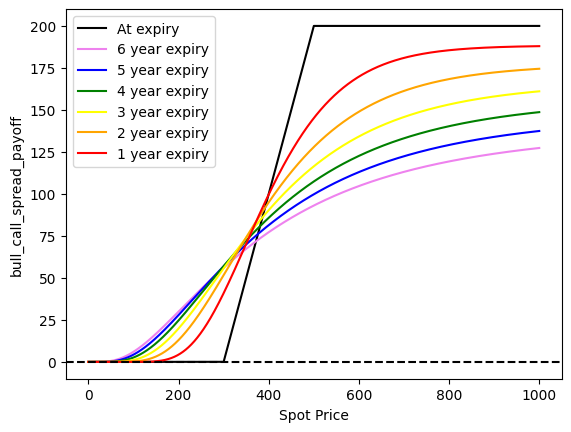

In [6]:
sns.lineplot(x = 'Spot Price', y = 'bull_call_spread_payoff', data = spread_1_df, color = 'black', label = 'At expiry')
sns.lineplot(x = 'Spot Price', y = 'bull_call_spread_premium', data = spread_1_df, color = 'violet', label = '6 year expiry')
sns.lineplot(x = 'Spot Price', y = 'bull_call_spread_premium', data = spread_2_df, color = 'blue', label = '5 year expiry')
sns.lineplot(x = 'Spot Price', y = 'bull_call_spread_premium', data = spread_3_df, color = 'green', label = '4 year expiry')
sns.lineplot(x = 'Spot Price', y = 'bull_call_spread_premium', data = spread_4_df, color = 'yellow', label = '3 year expiry')
sns.lineplot(x = 'Spot Price', y = 'bull_call_spread_premium', data = spread_5_df, color = 'orange', label = '2 year expiry')
sns.lineplot(x = 'Spot Price', y = 'bull_call_spread_premium', data = spread_6_df, color = 'red', label = '1 year expiry')
plt.axhline(0, linestyle = '--', color = 'black')

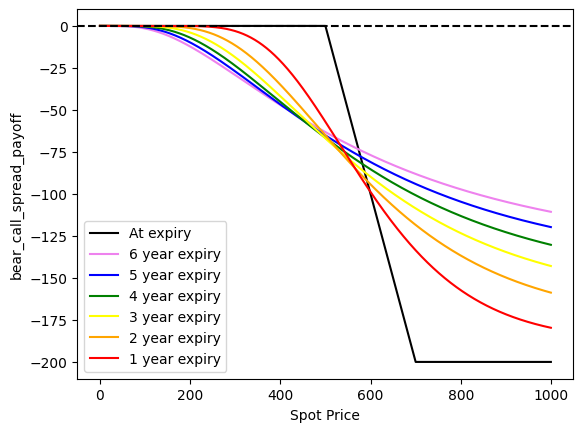

In [7]:
sns.lineplot(x = 'Spot Price', y = 'bear_call_spread_payoff', data = spread_1_df, color = 'black', label = 'At expiry')
sns.lineplot(x = 'Spot Price', y = 'bear_call_spread_premium', data = spread_1_df, color = 'violet', label = '6 year expiry')
sns.lineplot(x = 'Spot Price', y = 'bear_call_spread_premium', data = spread_2_df, color = 'blue', label = '5 year expiry')
sns.lineplot(x = 'Spot Price', y = 'bear_call_spread_premium', data = spread_3_df, color = 'green', label = '4 year expiry')
sns.lineplot(x = 'Spot Price', y = 'bear_call_spread_premium', data = spread_4_df, color = 'yellow', label = '3 year expiry')
sns.lineplot(x = 'Spot Price', y = 'bear_call_spread_premium', data = spread_5_df, color = 'orange', label = '2 year expiry')
sns.lineplot(x = 'Spot Price', y = 'bear_call_spread_premium', data = spread_6_df, color = 'red', label = '1 year expiry')
plt.axhline(0, linestyle = '--', color = 'black')

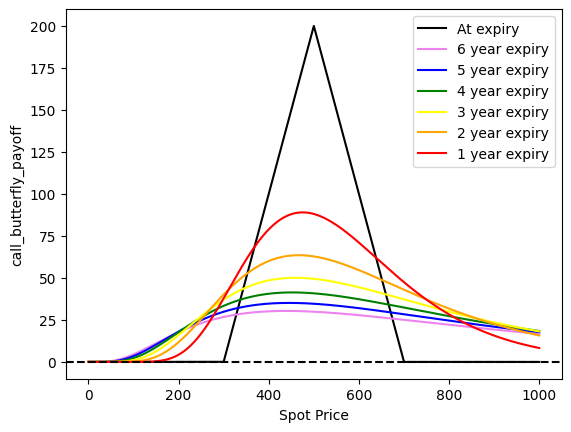

In [8]:
sns.lineplot(x = 'Spot Price', y = 'call_butterfly_payoff', data = spread_1_df, color = 'black', label = 'At expiry')
sns.lineplot(x = 'Spot Price', y = 'call_butterfly_premium', data = spread_1_df, color = 'violet', label = '6 year expiry')
sns.lineplot(x = 'Spot Price', y = 'call_butterfly_premium', data = spread_2_df, color = 'blue', label = '5 year expiry')
sns.lineplot(x = 'Spot Price', y = 'call_butterfly_premium', data = spread_3_df, color = 'green', label = '4 year expiry')
sns.lineplot(x = 'Spot Price', y = 'call_butterfly_premium', data = spread_4_df, color = 'yellow', label = '3 year expiry')
sns.lineplot(x = 'Spot Price', y = 'call_butterfly_premium', data = spread_5_df, color = 'orange', label = '2 year expiry')
sns.lineplot(x = 'Spot Price', y = 'call_butterfly_premium', data = spread_6_df, color = 'red', label = '1 year expiry')
plt.axhline(0, linestyle = '--', color = 'black')

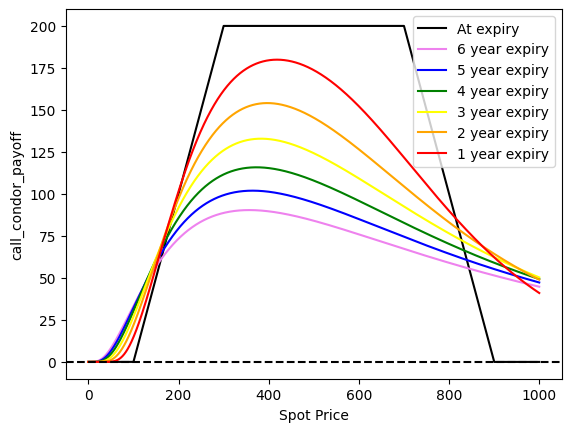

In [9]:
sns.lineplot(x = 'Spot Price', y = 'call_condor_payoff', data = spread_1_df, color = 'black', label = 'At expiry')
sns.lineplot(x = 'Spot Price', y = 'call_condor_premium', data = spread_1_df, color = 'violet', label = '6 year expiry')
sns.lineplot(x = 'Spot Price', y = 'call_condor_premium', data = spread_2_df, color = 'blue', label = '5 year expiry')
sns.lineplot(x = 'Spot Price', y = 'call_condor_premium', data = spread_3_df, color = 'green', label = '4 year expiry')
sns.lineplot(x = 'Spot Price', y = 'call_condor_premium', data = spread_4_df, color = 'yellow', label = '3 year expiry')
sns.lineplot(x = 'Spot Price', y = 'call_condor_premium', data = spread_5_df, color = 'orange', label = '2 year expiry')
sns.lineplot(x = 'Spot Price', y = 'call_condor_premium', data = spread_6_df, color = 'red', label = '1 year expiry')
plt.axhline(0, linestyle = '--', color = 'black')